# Session 2 Part 1: Going Further, Discovering class-imbalance in datasets

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

Since we have done the most basic training example, got our hands on skorch and on the dataset, we are going to repeat our process using a more realistic use case. This time, our dataset will be severely unbalanced (10% of all data will be images of aircrafts), like in real life (or not even like in real life but it's getting closer).

Here, we won't guide you, you will have to use what you learned in the previous notebooks as well as what you learned in previous data science class to try to devise a way to train a good model

You are going to:
- Do a first "naive" run with the full data
- Diagnose performance
- Try to improve it by tuning several factors:
  - The dataset itself
  - The optimization parameters
  - The network architecture

**Remember that "deep learning" is still considered somewhat a black art so it's hard to know in advance what will work.**


In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 13.5MB/s 


In [2]:
# Put your imports here
import numpy as np

In [3]:
# Global variables
TRAINVAL_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/large_aircraft_dataset.npz"

## Q0 Downloading & splitting the dataset

You will get the following:

- 50k images in training which you should use as training & validation
- 5k images in test, which you should only use to compute your final metrics on. **Don't ever use this dataset for early stopping / intermediary metrics**

<img src="https://i.stack.imgur.com/pXAfX.png" alt="pokemon" style="width: 400px;"/>

In [4]:
# Download the dataset
ds = np.DataSource("/tmp/")
f = ds.open(TRAINVAL_DATASET_URL, "rb")
trainval_dataset = np.load(f)
trainval_images = trainval_dataset["train_images"]
trainval_labels = trainval_dataset["train_labels"]
test_images = trainval_dataset["test_images"]
test_labels = trainval_dataset["test_labels"]

In [5]:
print(trainval_images.shape)
print(np.unique(trainval_labels, return_counts=True))

print(test_images.shape)
print(np.unique(test_labels, return_counts=True))

(46000, 64, 64, 3)
(array([0, 1]), array([41400,  4600]))
(10240, 64, 64, 3)
(array([0, 1]), array([9216, 1024]))


### a. Data Exploration

a. Can you plot some images ?

b. What is the aircraft/background ratio ?

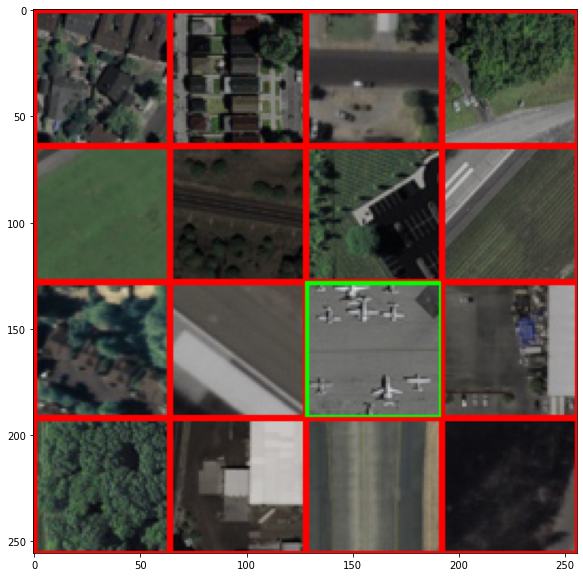

In [6]:
import cv2, matplotlib.pyplot as plt

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(trainval_images[i * grid_size + j])
        label = np.copy(trainval_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

In [7]:
np.unique(trainval_labels, return_counts=True)[1]/trainval_labels.shape[0]

array([0.9, 0.1])

10% des images sont des avions.

### b. Dataset Splitting

Here we will split the trainval_dataset to obtain a training and a validation dataset.

For example, try to use 20% of the images as validation

You must have seen that the dataset was really unbalanced, so a random sampling will not work...

Use stratified sampling to keep the label distribution between training and validation

In [8]:
# Hint to get your started
background_indexes = np.where(trainval_labels == 0)[0]
foreground_indexes = np.where(trainval_labels == 1)[0]

background_indexes = np.random.permutation(background_indexes)
foreground_indexes = np.random.permutation(foreground_indexes)

train_idxs_background, val_idxs_background = background_indexes[:int(.8*len(background_indexes))], background_indexes[int(.8*len(background_indexes)):]
train_idxs_foreground, val_idxs_foreground = foreground_indexes[:int(.8*len(foreground_indexes))], foreground_indexes[int(.8*len(foreground_indexes)):]

train_idxs = np.concatenate([train_idxs_background, train_idxs_foreground])
val_idxs = np.concatenate([val_idxs_background, val_idxs_foreground])

train_images = trainval_images[train_idxs]
train_labels = trainval_labels[train_idxs]
val_images = trainval_images[val_idxs]
val_labels = trainval_labels[val_idxs]

In [9]:
train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

((36800, 64, 64, 3), (36800,), (9200, 64, 64, 3), (9200,))

## Q1. Training & metrics

During Session 1, you learnt how to set up your environment on Colab, train a basic CNN on a small training set and plot metrics. Now let's do it again !

### First run

Once you have downloaded & created your training & validation dataset, use the notebook from Session 1 to get:

a. Training of the model using steps seen during Session 1

b. Compute and plot metrics (confusion matrix, ROC curve) based on this training

c. Compare the metrics between this new dataset and the one from Session 1

d. What did you expect ? Is your model working well ?

In [10]:
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

#### Create Dataloaders


In [11]:
class NpArrayDataset(Dataset):
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]
        y = self.labels[index]

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x)

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y)

        return x, y

In [12]:
# transform to convert np array in range [0,255] to torch.Tensor [0.,1.]
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

target_transforms = None

# load the training data
train_set = NpArrayDataset(
    images=train_images, labels=train_labels, image_transforms=image_transforms, label_transforms=target_transforms
)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# load the validation data
validation_set = NpArrayDataset(
    images=val_images, labels=val_labels, image_transforms=image_transforms, label_transforms=target_transforms
)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

Inverse transform is OK ? True
Label 0


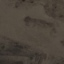

In [13]:
x, y = train_set[3]
x = x.numpy()
x = (x * 255.0).astype(np.uint8).transpose((1, 2, 0))

print("Inverse transform is OK ? {}".format(np.all(train_set.images[3] == x)))
print("Label {}".format(y))
Image.fromarray(x.astype(np.uint8))

#### Create model

In [14]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [15]:
def model_fn():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 64, 3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(6 * 6 * 64, 256),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(64, 2),
        nn.LogSoftmax(dim=-1),
    )

    return model


model = model_fn()

# moving model to gpu if available
model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=256, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): Linear(in_features=256, out_features=64, bias=True)
  (17): ReLU()

#### Define high-level training functions

In [16]:
import ignite.engine
import ignite.handlers
import ignite.metrics
import ignite.utils
from ignite.engine import Events

In [17]:
# declare optimizers and loss
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

In [18]:
# defining the number of epochs
epochs = 12

# creating trainer
trainer = ignite.engine.create_supervised_trainer(model=model, optimizer=optimizer, loss_fn=criterion, device=DEVICE)

# create metrics
metrics = {
    "accuracy": ignite.metrics.Accuracy(),
    "nll": ignite.metrics.Loss(criterion),
    "cm": ignite.metrics.ConfusionMatrix(num_classes=2),
}

ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

# Evaluators
train_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)
val_evaluator = ignite.engine.create_supervised_evaluator(model, metrics=metrics, device=DEVICE)

# Logging
train_evaluator.logger = ignite.utils.setup_logger("train")
val_evaluator.logger = ignite.utils.setup_logger("val")

# init variables for logging
training_history = {"accuracy": [], "loss": []}
validation_history = {"accuracy": [], "loss": []}
last_epoch = []

In [19]:
model_name = "basic_cnn"
dataset_name = "large_aircrafts"

checkpointer = ignite.handlers.ModelCheckpoint(
    "./saved_models",
    filename_prefix=dataset_name,
    n_saved=2,
    create_dir=True,
    save_as_state_dict=True,
    require_empty=False,
)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {model_name: model})

In [20]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    last_epoch.append(0)
    training_history["accuracy"].append(accuracy)
    training_history["loss"].append(loss)
    print(
        "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics["accuracy"] * 100
    loss = metrics["nll"]
    validation_history["accuracy"].append(accuracy)
    validation_history["loss"].append(loss)
    print(
        "Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(
            trainer.state.epoch, accuracy, loss
        )
    )

In [21]:
trainer.run(train_loader, max_epochs=epochs)

2020-11-30 15:13:08,124 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:13:11,901 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:13:11,902 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:13:11,904 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 1  Avg accuracy: 90.62 Avg loss: 0.24


2020-11-30 15:13:12,857 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:13:12,858 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 1  Avg accuracy: 90.55 Avg loss: 0.24


2020-11-30 15:13:19,207 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:13:22,919 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:13:22,919 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:13:22,921 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 2  Avg accuracy: 92.61 Avg loss: 0.19


2020-11-30 15:13:23,864 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:13:23,865 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 2  Avg accuracy: 92.33 Avg loss: 0.19


2020-11-30 15:13:30,156 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:13:33,873 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:13:33,874 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:13:33,875 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 3  Avg accuracy: 93.92 Avg loss: 0.17


2020-11-30 15:13:34,809 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:13:34,810 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 3  Avg accuracy: 93.71 Avg loss: 0.17


2020-11-30 15:13:41,100 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:13:44,784 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:13:44,785 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:13:44,788 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 4  Avg accuracy: 94.60 Avg loss: 0.15


2020-11-30 15:13:45,730 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:13:45,731 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 4  Avg accuracy: 94.49 Avg loss: 0.15


2020-11-30 15:13:52,002 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:13:55,674 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:13:55,675 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:13:55,677 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 5  Avg accuracy: 94.81 Avg loss: 0.14


2020-11-30 15:13:56,619 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:13:56,619 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 5  Avg accuracy: 94.43 Avg loss: 0.14


2020-11-30 15:14:02,949 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:14:06,730 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:14:06,731 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:14:06,734 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 6  Avg accuracy: 95.45 Avg loss: 0.13


2020-11-30 15:14:07,690 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:14:07,691 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 6  Avg accuracy: 95.32 Avg loss: 0.13


2020-11-30 15:14:13,938 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:14:17,568 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:14:17,569 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:14:17,571 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 7  Avg accuracy: 95.43 Avg loss: 0.12


2020-11-30 15:14:18,508 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:14:18,509 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 7  Avg accuracy: 95.13 Avg loss: 0.13


2020-11-30 15:14:24,754 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:14:28,415 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:14:28,415 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:14:28,417 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 8  Avg accuracy: 95.95 Avg loss: 0.11


2020-11-30 15:14:29,344 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:14:29,345 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 8  Avg accuracy: 95.93 Avg loss: 0.11


2020-11-30 15:14:35,554 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:14:39,185 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:14:39,186 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:14:39,191 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 9  Avg accuracy: 96.21 Avg loss: 0.10


2020-11-30 15:14:40,104 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:14:40,104 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 9  Avg accuracy: 96.17 Avg loss: 0.10


2020-11-30 15:14:46,314 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:14:49,968 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:14:49,969 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:14:49,970 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 10  Avg accuracy: 96.38 Avg loss: 0.10


2020-11-30 15:14:50,905 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:14:50,906 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 10  Avg accuracy: 96.33 Avg loss: 0.10


2020-11-30 15:14:57,123 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:15:00,750 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:15:00,751 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:15:00,752 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 11  Avg accuracy: 96.26 Avg loss: 0.10


2020-11-30 15:15:01,687 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:15:01,688 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 11  Avg accuracy: 96.37 Avg loss: 0.10


2020-11-30 15:15:07,894 train INFO: Engine run starting with max_epochs=1.
2020-11-30 15:15:11,520 train INFO: Epoch[1] Complete. Time taken: 00:00:04
2020-11-30 15:15:11,521 train INFO: Engine run complete. Time taken: 00:00:04
2020-11-30 15:15:11,525 val INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 12  Avg accuracy: 96.54 Avg loss: 0.09


2020-11-30 15:15:12,442 val INFO: Epoch[1] Complete. Time taken: 00:00:01
2020-11-30 15:15:12,443 val INFO: Engine run complete. Time taken: 00:00:01


Validation Results - Epoch: 12  Avg accuracy: 96.27 Avg loss: 0.09


State:
	iteration: 6900
	epoch: 12
	epoch_length: 575
	max_epochs: 12
	output: 0.10817263275384903
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: torch.utils.data.dataloader.DataLoader
	seed: <class 'NoneType'>
	times: <class 'dict'>

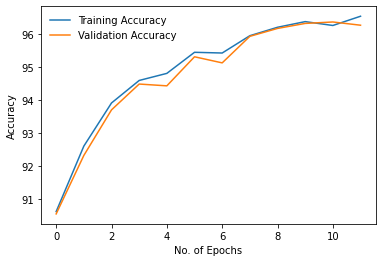

In [22]:
plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

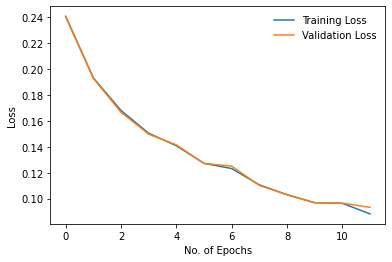

In [23]:
plt.plot(training_history["loss"], label="Training Loss")
plt.plot(validation_history["loss"], label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

#### Results on test dataset

In [24]:
test_ds = NpArrayDataset(
    images=test_images, labels=test_labels, image_transforms=image_transforms, label_transforms=target_transforms
)

In [25]:
import tqdm

In [26]:
y_true = []
y_pred = []

# Send model to correct device
model.to(DEVICE)

# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_ds, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = torch.exp(model.forward(x))
        y = y.to("cpu").numpy()

        y_t = int(y_t.to("cpu").numpy())

        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.asarray(y_true)

predicting: 100%|██████████| 10240/10240 [00:09<00:00, 1059.56it/s]


In [27]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [28]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix")
confusion_matrix(y_true, y_pred_classes)

Confusion matrix


array([[9171,   45],
       [ 310,  714]])

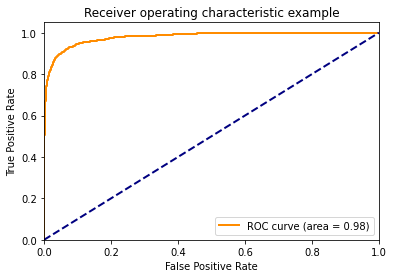

In [51]:
from sklearn.metrics import auc, roc_curve

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(
    y_true,
    y_pred[:, 1],
)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#### Misclassified examples

In [39]:
y_pred_classes[38], y_true[38]

(0, 1)

Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 1, real: 0
Prediction: 0, real: 1
Prediction: 1, real: 0
Prediction: 0, real: 1
Prediction: 0, real: 1
Prediction: 0, real: 1


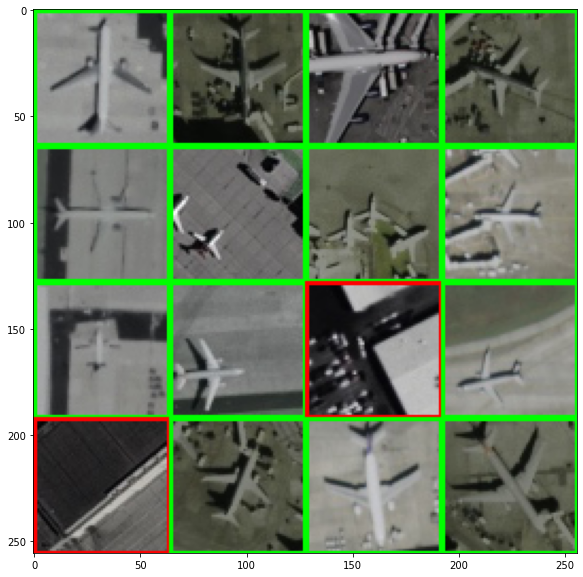

In [40]:
misclassified_idxs = np.where(y_pred_classes != y_true)[0]

misclassified_images = test_images[misclassified_idxs]
misclassified_labels = test_labels[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        print('Prediction: {}, real: {}'.format(y_pred_classes[misclassified_idxs[i*grid_size+j]], misclassified_labels[i*grid_size+j]))
        img = np.copy(misclassified_images[i * grid_size + j])
        lbl = np.copy(misclassified_labels[i * grid_size + j])
        color = (0, 255, 0) if lbl == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

### Test metrics, introduction to PR Curves

During the previous notebook you plotted the Receiver Operating Characteristic curve. This is not ideal when dealing with imbalanced dataset since the issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of **false positives**. Furthermore, in ROC curve calculation, true negatives don't have such meaning any longer.

Instead this time we will plot the Precision Recall curve of our model which uses precision and recall to evaluate models.

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

Refer here for a tutorial on how to plot such curve:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

More details on PR Curve:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

**e. Plot the ROC curve of your model as well as its PR Curve, on the test set, compare them, which is easier to interpret ?**

**f. Can you understand why PR curve may be more useful than ROC curve for diagnosing model performance when dealing with imbalanced data ?**

**g. What is Fbeta-Score ? How can it help ? How do you chose beta?**

Some reading: https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c

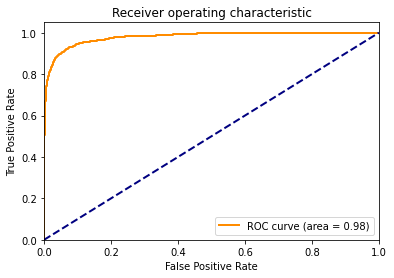

In [56]:
from sklearn.metrics import auc, roc_curve

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(
    y_true,
    y_pred[:, 1],
)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [62]:
from sklearn.metrics import average_precision_score
pr = average_precision_score(y_true, y_pred[:,1])
print('Precision-recall score:', pr)

Precision-recall score: 0.9034833951392625


In [64]:
?precision_recall_curve

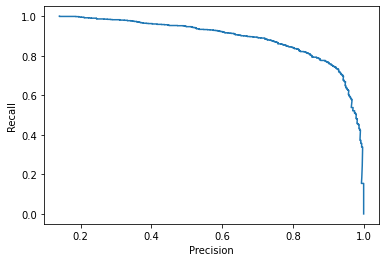

In [70]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()


## Q2. Let's improve our model's performance

We will try several things below. Those steps are only indicative and you are free to pursue other means of improving your model.

Should you be lost, we refer you to the excellent "A Recipe for Training Neural Networks" article : https://karpathy.github.io/2019/04/25/recipe/

![image.png](https://github.com/fchouteau/isae-practical-deep-learning/blob/master/docs/static/img/mlsystem.png?raw=1)

### a. Tackling the imbalanced data problem

Go through your data: is the dataset balanced ? If now, which steps can I do to solve this imbalance problem ?

- Which step would you take ?
- **Don't forget to apply the same step on you train and validation dataset** but **not on your test set** as your test set should represent the final data distribution

Try to decide and a method to modify only the dataset and rerun your training. Did performance improve ?


HINT:
- It's usually a mix of oversampling the minority class and undersampling the majority class

Some readings:
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets (very well done)
- https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/ (a bigger synthesis)
- https://machinelearningmastery.com/category/imbalanced-classification/

In [73]:
train_images.shape, val_images.shape

((36800, 64, 64, 3), (9200, 64, 64, 3))

In [97]:
images_background = trainval_images[trainval_labels==0]
images_foreground = trainval_images[trainval_labels==1]

print(images_background.shape, images_foreground.shape)
# we have 41400 images of backgrounds, 4600 images of foreground

# data augmentation on foreground
import torchvision
foreground_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
])
images_foreground = np.concatenate(4*[images_foreground, ])
# 4*4600 = 18400 images of foreground

# under-sampling on background images
images_background = images_background[np.random.choice(images_background.shape[0], size=len(images_foreground))]

images_foreground.shape, images_background.shape

(41400, 64, 64, 3) (4600, 64, 64, 3)


((18400, 64, 64, 3), (18400, 64, 64, 3))

In [100]:
trainval_images_balanced = np.concatenate([images_foreground, images_background])
trainval_labels_balanced = np.concatenate([[0 for _ in images_foreground], [1 for _ in images_background]])

idxs = np.random.permutation(np.arange(trainval_images_balanced.shape[0]))

train_idxs, val_idxs = idxs[: int(0.8 * len(idxs))], idxs[int(0.8 * len(idxs)) :]

train_images = trainval_images_balanced[train_idxs]
train_labels = trainval_labels_balanced[train_idxs]
val_images = trainval_images_balanced[val_idxs]
val_labels = trainval_labels_balanced[val_idxs]

In [101]:
train_images.shape, val_images.shape

((29440, 64, 64, 3), (7360, 64, 64, 3))

### b. Optimizer and model modifications

i ) Now that you have worked on your dataset and decided to undersample it, it's time to tune your network and your training configuration

In Session 1, you tested two descent gradient. What is the effect of its modification? Apply it to your training and compare metrics.

ii ) An other important parameter is the learning rate, you can [check its effect on the behavior of your training](https://developers.google.com/machine-learning/crash-course/fitter/graph).

iii) There is no absolute law concerning the structure of your deep Learning model. During the [Deep Learning class](%matplotlib inline) you had an overview of existing models

You can operate a modification on your structure and observe the effect on final metrics. Of course, remain consistent with credible models, cf Layer Patterns chapter on this "must view" course : http://cs231n.github.io/convolutional-networks/

<img src="https://github.com/fchouteau/isae-practical-deep-learning/blob/master/docs/static/img/comparison_architectures.png?raw=1" alt="pokemon" style="width: 400px;"/>

In [ ]:
# Q2.b here

### c. Going Further

Here is an overview of [possible hyperparameter tuning when training Convolutional Neural Networks](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8)

You can try and apply those techniques to your use case.

- Does these techniques yield good results ? What about the effort-spent-for-performance ratio ?
- Do you find it easy to keep track of your experiments ?
- What would you need to have a better overview of the effects of these search ?

Don't spend too much time on this part as the next is more important. You can come back to it after you're finished

In [ ]:
# Q2.c here

## Q3. Full Test whole dataset & more improvements

a. Now that you have optimised your structure for your dataset, you will apply your model to the test dataset to see the final metrics. Plot all your metrics using the full imbalanced test set. Is it good enough ?
If you think so, you can apply it to new images using the sliding window technique with the 3rd notebook

- Did it bring any improvements ?

In [ ]:
# Q3a

b. If you're not satisfied with the output of your model, consider the following idea: Training a new model with the failures of your previous model.
Try the following:
- Get all the images with the "aircraft" label
- Get all the images with the "background" label where your best model was wrong (predicted aircraft), as well as some of the background where it was right.
- Train a new model or retrain your existing one on this dataset.


In [ ]:
# Q3b

c . **SAVE YOUR MODEL**

In [ ]:
# Q3c

**Have you saved your model ??** You will need it for the next notebook